In [1]:
%cd C:

C:\


In [2]:
import warnings

warnings.filterwarnings("ignore", ".*CUDA.*")

In [3]:
from yolov5 import train, val, detect, export
import yolov5
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import easyocr
from PIL import Image, ImageOps
import cv2
import pytesseract
import imutils

# pytesseract.pytesseract.tesseract_cmd = r'S:\Tesseract\tesserapytesseractt.exe'
%cd D:\Projects\plate-recognition\core-model

D:\Projects\plate-recognition\core-model


In [4]:
class IninitalModel:
    def __init__(self, image, weights, confidence):
        self.image = image
        self.weights = weights
        self.confidence = confidence

    def prepare_model(self):
        model = yolov5.load(self.weights)
        # Set the confidence threshold value
        model.conf = self.confidence

        # inference with larger input size
        results = model(self.image)

        # inference with test time augmentation
        results = model(self.image, augment=True)

        # parse results
        predictions = results.pred[0]
        boxes = predictions[:, :4].tolist()[0]  # x1, y1, x2, y2

        # show detection bounding boxes on image
        results.show()

        return boxes

In [5]:
class OCRPlateLicense:
    def __init__(self, path_img, bounding_boxes, languages):
        self.image = Image.open(path_img)
        self.bounding_boxes = bounding_boxes
        self.languages = languages

    def image_rotation(self, image):
        if hasattr(image, "_getexif"):
            exif_data = image._getexif()
            if exif_data is not None:
                orientation = exif_data.get(0x0112)
                if orientation is not None:
                    # Rotate the image accordingly
                    if orientation == 3:
                        image = image.rotate(180, expand=True)
                    elif orientation == 6:
                        image = image.rotate(270, expand=True)
                    elif orientation == 8:
                        image = image.rotate(90, expand=True)
        return image

    def crop_image(self):
        image = self.image_rotation(self.image)
        return np.asarray(
            image.crop(
                (
                    self.bounding_boxes[0],
                    self.bounding_boxes[1],
                    self.bounding_boxes[2],
                    self.bounding_boxes[3],
                )
            )
        )

    def image_without_processing(self):
        image = self.crop_image()
        return self.predict_characters(image, self.languages)

    def image_binarization(self):
        image = self.crop_image()
        grayscale_resize_test_license_plate = cv2.cvtColor(
            np.array(image), cv2.COLOR_BGR2GRAY
        )
        opencv_image = cv2.cvtColor(
            np.array(grayscale_resize_test_license_plate), cv2.COLOR_RGB2BGR
        )
        im_gray = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)

        _, mask = cv2.threshold(im_gray, thresh=100, maxval=255, type=cv2.THRESH_BINARY)
        image = np.asarray(Image.fromarray(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)))
        return self.predict_characters(image, self.languages)

    def image_gaussian_blur(self):
        image = self.crop_image()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15
        )
        _, labels = cv2.connectedComponents(thresh)
        mask = np.zeros(thresh.shape, dtype="uint8")
        # Set lower bound and upper bound criteria for characters
        total_pixels = image.shape[0] * image.shape[1]
        lower = total_pixels // 150  # heuristic param, can be fine tuned if necessary
        upper = total_pixels // 20  # heuristic param, can be fine tuned if necessary

        # Loop over the unique components
        for i, label in enumerate(np.unique(labels)):
            # If this is the background label, ignore it
            if label == 0:
                continue

            # Otherwise, construct the label mask to display only connected component
            # for the current label
            labelMask = np.zeros(thresh.shape, dtype="uint8")
            labelMask[labels == label] = 255
            numPixels = cv2.countNonZero(labelMask)

            # If the number of pixels in the component is between lower bound and upper bound,
            # add it to our mask
            if numPixels > lower and numPixels < upper:
                mask = cv2.add(mask, labelMask)

        return self.predict_characters(np.asarray(mask), self.languages)

    def predict_characters(self, image, languages):
        results = []
        for language in languages:
            reader = easyocr.Reader(languages, gpu=True)
            results.append(reader.readtext(image, detail=0))
        return results

YOLOv5  2023-5-22 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 379 layers, 35275944 parameters, 0 gradients, 49.3 GFLOPs
Adding AutoShape... 


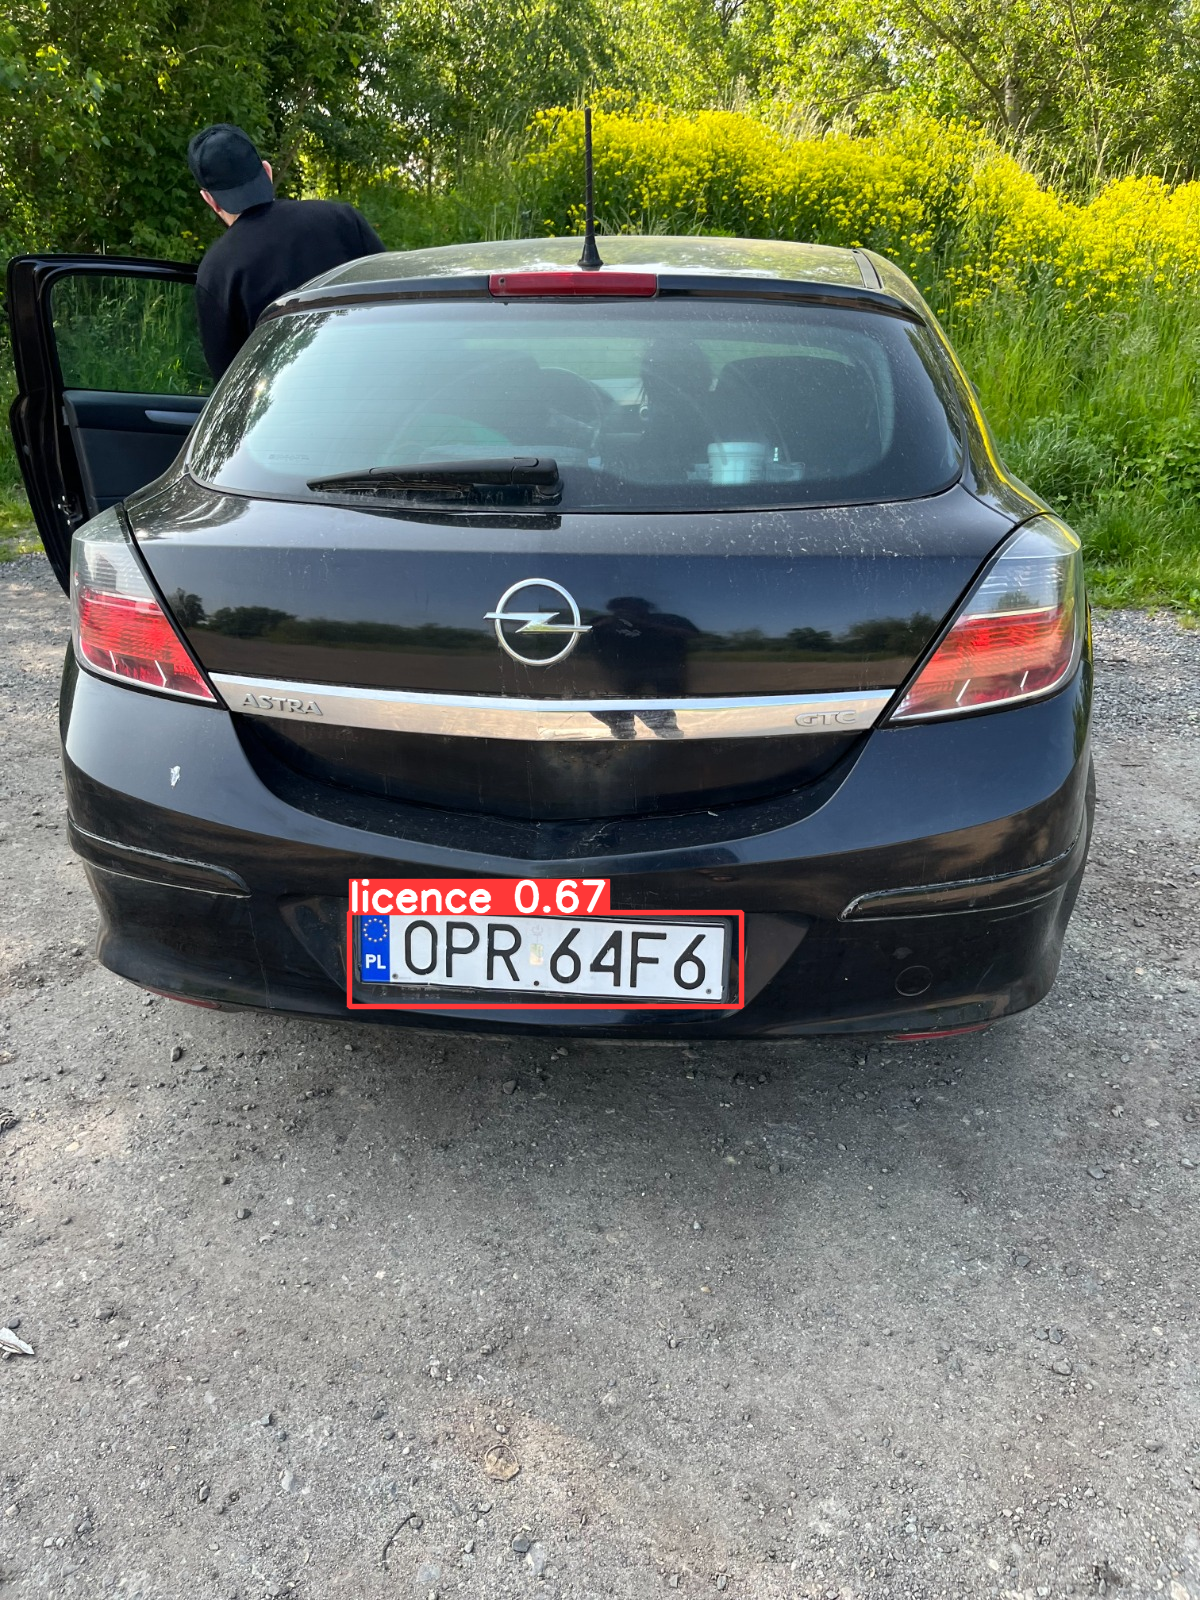

In [6]:
image = "opel.jpeg"
weights = "best_model.pt"
confidence = 0.25

model = IninitalModel(image, weights, confidence)
boxes = model.prepare_model()
test = OCRPlateLicense(image, boxes, ["en", "pl", "de"])

In [7]:
t1 = test.image_without_processing()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [8]:
t2 = test.image_binarization()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [9]:
t3 = test.image_gaussian_blur()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [10]:
def remove_illegal_characters(results, characters_to_replace):
    new_results = []
    for values in results:
        for value in values:
            new_values = [element for element in value]
            for char in characters_to_replace:
                new_values = [element.replace(char, "") for element in new_values]
            new_results.append(new_values)
    return new_results


def calculate_probability(prediction_results):
    prediction_results = [
        [item for item in sublist if item != "PL"] for sublist in prediction_results
    ]
    occurrence_counts = {}

    for result in prediction_results:
        for index, character in enumerate(result):
            if index not in occurrence_counts:
                occurrence_counts[index] = {}

            if character not in occurrence_counts[index]:
                occurrence_counts[index][character] = 1
            else:
                occurrence_counts[index][character] += 1

    most_probable = []

    for index in occurrence_counts:
        characters = occurrence_counts[index]
        max_count = max(characters.values())
        most_frequent_characters = [
            char for char in characters if characters[char] == max_count
        ]
        last_most_frequent_character = max(
            most_frequent_characters, key=lambda x: list(characters.keys()).index(x)
        )
        most_probable.append(last_most_frequent_character)

    return most_probable


def signs(license_plate):
    license_plate = [
        trash
        for trash in license_plate
        if (trash != "0" or trash.lower() == "pl") and len(trash) <= 8
    ]

    tmp = "".join(license_plate)
    for sign in license_plate:
        if len(sign) == 2 and sign.lower() == "pl":
            return tmp[2:]

    return "".join(license_plate)[:8]

In [11]:
[t1, t2, t3]

[[["PL'", 'OPR64F6'], ["PL'", 'OPR64F6'], ["PL'", 'OPR64F6']],
 [['OPR64F6'], ['OPR64F6'], ['OPR64F6']],
 [['JOPR 64F6'], ['JOPR 64F6'], ['JOPR 64F6']]]

In [12]:
characters_to_replace = [":", '"', "]", "[", ".", ",", "'", " ", "|", "-"]
results = remove_illegal_characters([t1, t2, t3], characters_to_replace)

In [13]:
result_prob = calculate_probability(results)
result_prob

['OPR64F6']

In [14]:
signs(result_prob)

'OPR64F6'